# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pyportfolio/pyportfolioopt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/PyPortfolio/PyPortfolioOpt/blob/main/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/pyportfolio/pyportfolioopt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/pyportfolio/pyportfolioopt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)

In [6]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/pyportfolio/pyportfolioopt.git')
    os.chdir('PyPortfolioOpt/cookbook')


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [8]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [9]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Close"]
prices.tail()

/var/folders/_3/k_9k5d5n5zz57w7qfll9rzs40000gn/T/ipykernel_60334/2708075403.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(tickers, period="max")
[*********************100%***********************]  10 of 10 completed


Ticker,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2025-11-05,250.199997,52.450001,935.030029,111.360001,400.410004,68.510002,305.670013,507.160004,3.57,82.879997
2025-11-06,243.039993,53.290001,923.580017,110.489998,401.459991,69.059998,298.410004,497.100006,3.59,82.220001
2025-11-07,244.410004,53.200001,922.739990,110.739998,410.179993,70.550003,299.660004,496.820007,3.56,85.570000
2025-11-10,248.399994,53.419998,915.559998,112.239998,407.589996,70.519997,299.100006,506.000000,3.65,84.599998
2025-11-11,249.100006,53.630001,913.859985,114.849998,409.230011,71.610001,306.829987,508.679993,3.63,86.419998


In [10]:
market_prices = yf.download("SPY", period="max")["Close"]
market_prices.head()

/var/folders/_3/k_9k5d5n5zz57w7qfll9rzs40000gn/T/ipykernel_60334/3562423400.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_prices = yf.download("SPY", period="max")["Close"]
[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
1993-01-29,24.313040
1993-02-01,24.485947
1993-02-02,24.537836
1993-02-03,24.797226
1993-02-04,24.900978


In [11]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3780701847552,
 'AMZN': 2662932938752,
 'NAT': 768654912,
 'BAC': 391632846848,
 'DPZ': 13826333696,
 'DIS': 206492696576,
 'KO': 308038205440,
 'MCD': 218510311424,
 'COST': 405003698176,
 'SBUX': 98250891264}

## Constructing the prior

In [12]:
import pypfopt
pypfopt.__version__

'1.5.6'

In [13]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

np.float64(3.426860188963759)

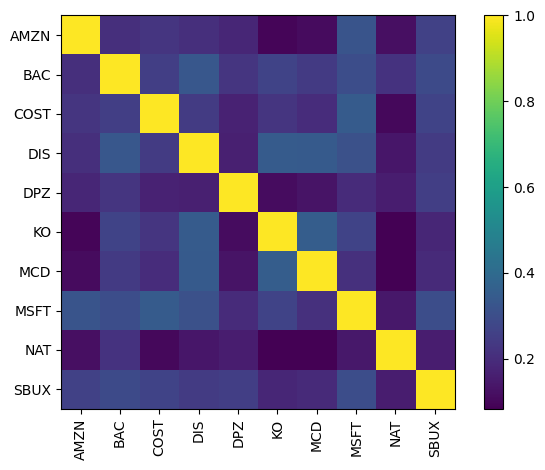

In [14]:
plotting.plot_covariance(S, plot_correlation=True);

In [15]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
AMZN    0.217688
BAC     0.104540
COST    0.077448
DIS     0.092606
DPZ     0.039139
KO      0.051818
MCD     0.056672
MSFT    0.160434
NAT     0.041953
SBUX    0.078963
dtype: float64

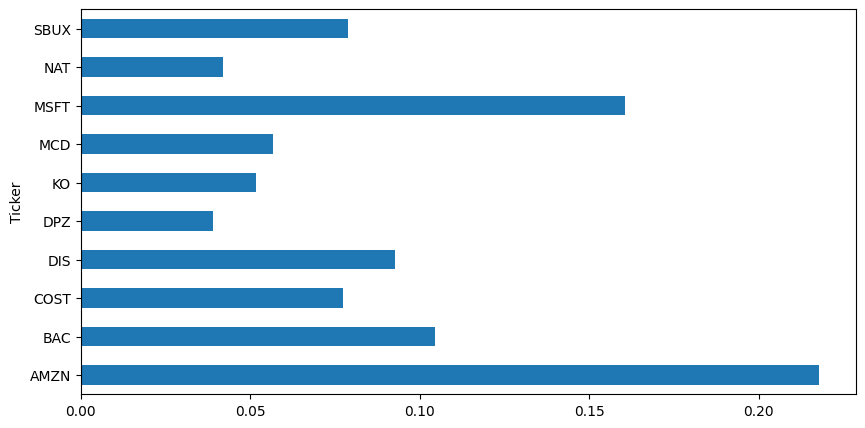

In [16]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [17]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [18]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [19]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

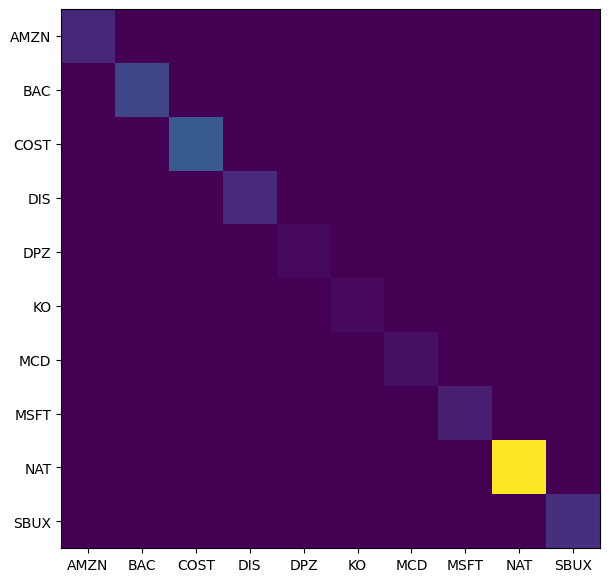

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [21]:
np.diag(bl.omega)

array([0.0045619 , 0.00873095, 0.01198575, 0.00493244, 0.00088379,
       0.00112096, 0.0016701 , 0.0034398 , 0.04152296, 0.00552791])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [22]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [23]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [24]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [25]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
AMZN    0.183882
BAC     0.135815
COST    0.067281
DIS     0.074143
DPZ     0.107602
KO      0.007914
MCD     0.102838
MSFT    0.107538
NAT     0.063471
SBUX    0.086751
dtype: float64

We can visualise how this compares to the prior and our views:

In [26]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.217688,0.183882,0.10
BAC,0.104540,0.135815,0.30
COST,0.077448,0.067281,0.05
DIS,0.092606,0.074143,0.05
DPZ,0.039139,0.107602,0.20
KO,0.051818,0.007914,-0.05
MCD,0.056672,0.102838,0.15
MSFT,0.160434,0.107538,0.10
NAT,0.041953,0.063471,0.50
SBUX,0.078963,0.086751,0.10


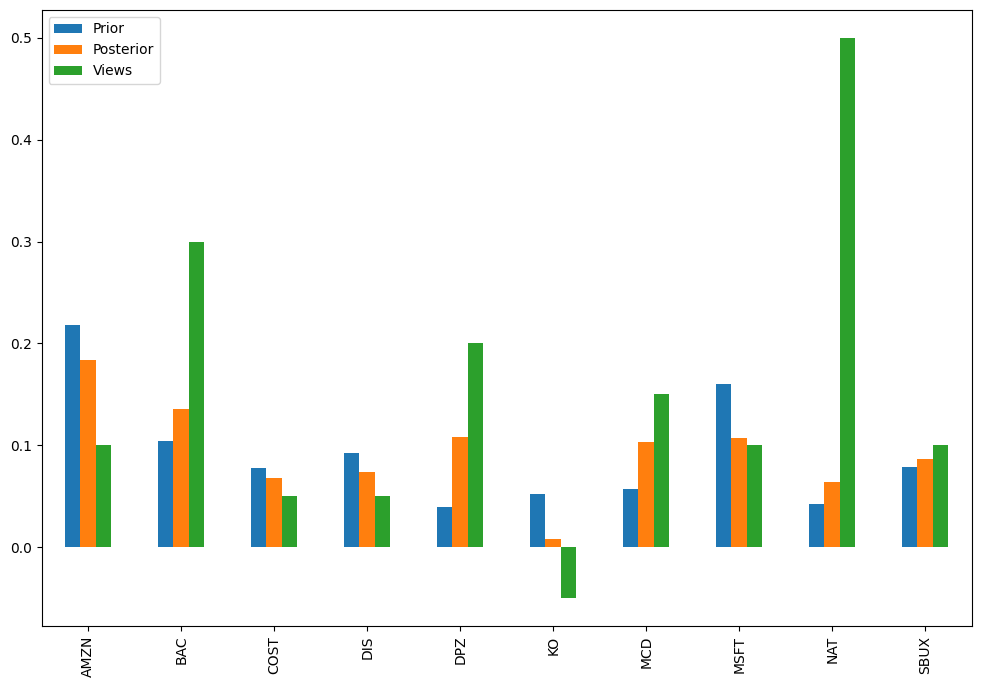

In [27]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

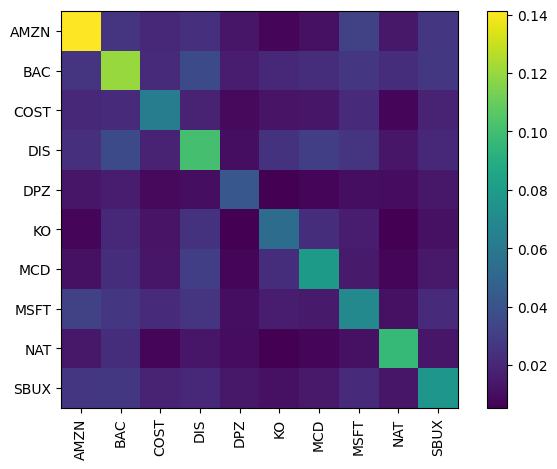

In [28]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [29]:
from pypfopt import EfficientFrontier, objective_functions

In [30]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/thomasschmelzer/projects/PyPortfolioOpt/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.20061),
             ('BAC', 0.14324),
             ('COST', 0.0697),
             ('DIS', 0.07017),
             ('DPZ', 0.12808),
             ('KO', 0.0),
             ('MCD', 0.11522),
             ('MSFT', 0.1165),
             ('NAT', 0.06627),
             ('SBUX', 0.09021)])

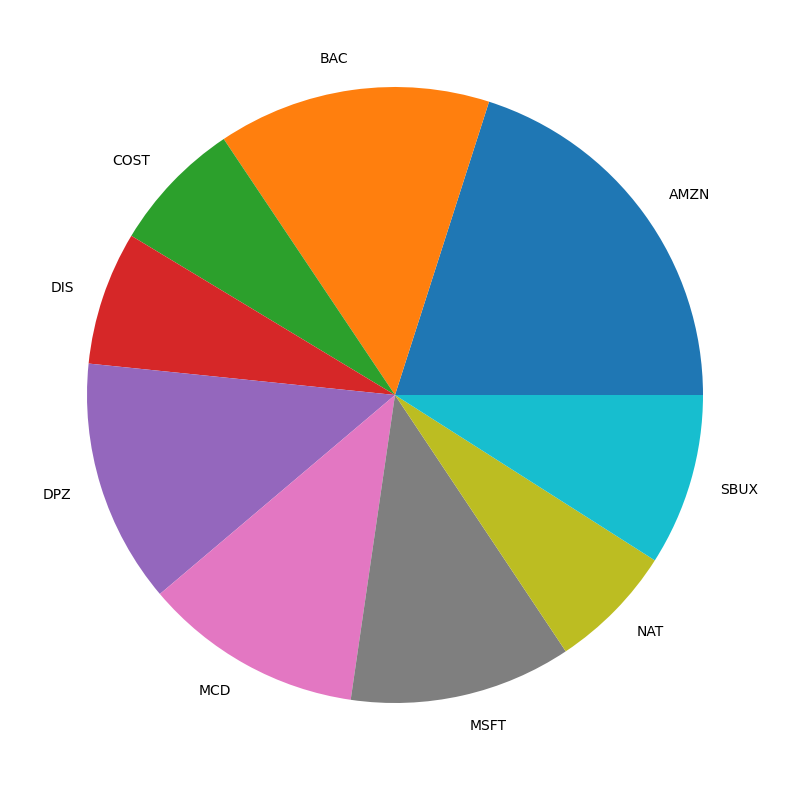

In [31]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [32]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $16.30


{'AMZN': 16,
 'BAC': 54,
 'COST': 2,
 'DIS': 13,
 'DPZ': 6,
 'MCD': 7,
 'MSFT': 4,
 'NAT': 366,
 'SBUX': 21}